In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sys.version

sys.path.append("../../")

from src.ad_hmm import sku_predict
from src.utils import *

In [3]:
%load_ext autoreload 
%autoreload 2

### Input data

In [4]:
train_test = pd.read_csv("../../data/train_validation_marker.csv")
train_test["SALES_DATE"] = pd.to_datetime(train_test["SALES_DATE"])
print (train_test.shape)

train_test["if_promo"] = (~train_test["PROMO_PRICE"].isin(["?"])).astype("int")
train_test["if_competitor"] = (~train_test["COMPETITOR_PRICE"].isin(["?"])).astype("int")

train_test["min_sales_price"] = pd.to_numeric(np.where(train_test.if_promo>0, train_test.PROMO_PRICE,\
                                                       train_test.RETAIL_PRICE))

train_test["comp_price_clean"] = pd.to_numeric(np.where(train_test.if_competitor>0,train_test.COMPETITOR_PRICE, np.nan))
train_test["price_delta"] = np.where(train_test.if_competitor>0, train_test.min_sales_price - train_test.comp_price_clean,\
                                   -train_test.min_sales_price)

(846632, 15)


### Pivot data

In [5]:
train_test_pivot = train_test.pivot(index='SALES_DATE', columns='Encoded_SKU_ID',\
                   values=['DAILY_UNITS',"if_promo","if_competitor","min_sales_price","price_delta",\
                          "validation","validation_clean"])
train_test_pivot.columns = train_test_pivot.columns.swaplevel(0, 1)

In [6]:
sku_id = 50
train_test_sku = train_test_pivot.loc[:,(sku_id,)].copy()
train_test_sku["ad_time"] = list(range(1,train_test_sku.shape[0]+1))

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_22097/4124826544.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  train_test_sku = train_test_pivot.loc[:,(sku_id,)].copy()


In [7]:
train_sku = train_test_sku[(train_test_sku.validation==False) & (train_test_sku.validation_clean==True)]
validation_sku = train_test_sku[(train_test_sku.validation==True) & (train_test_sku.validation_clean==True)]
train_sku.shape,validation_sku.shape

((1520, 8), (7, 8))

### STL decomposition

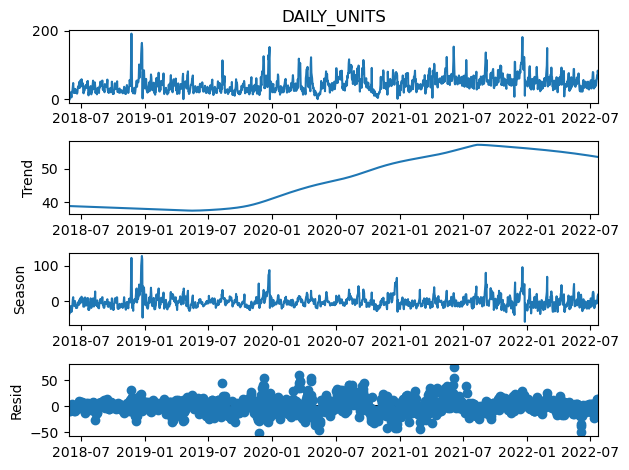

In [8]:
from statsmodels.tsa.seasonal import STL
res = STL(train_sku["DAILY_UNITS"], period = 365).fit()
res.plot()
plt.show()

### MSTL decomp

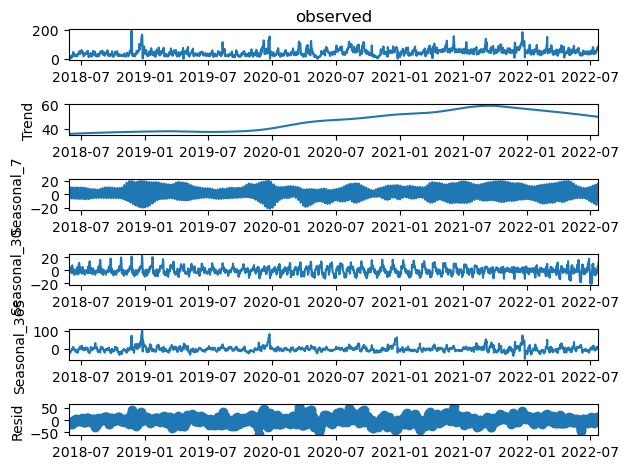

In [9]:
from statsmodels.tsa.seasonal import MSTL
res_m = MSTL(train_sku["DAILY_UNITS"], periods=(7, 30, 365)).fit()
res_m.plot()
plt.show()

In [10]:
train_sku["STL_resid"] = res.resid
train_sku["STL_trend"] = res.trend
train_sku["STL_seasonal"] = res.seasonal

train_sku["MSTL_resid"] = res_m.resid
train_sku["MSTL_trend"] = res_m.trend
train_sku[["MSTL_seasonal_7","MSTL_seasonal_30","MSTL_seasonal_365"]] = res_m.seasonal

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_22097/1610264522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sku["STL_resid"] = res.resid
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_22097/1610264522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sku["STL_trend"] = res.trend
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_22097/1610264522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

### Try tslearn

In [11]:
from tsprial.forecasting import *
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARIMA
# from pmdarima import auto_arima
from scipy.stats import boxcox
from scipy.special import inv_boxcox
# from math import exp,log

In [12]:
model_dict={} #dict to save model
y_pred_dict={} #dict to save predictions on test
pred_cols = ['if_promo', 'if_competitor', 'min_sales_price',
       'price_delta',"ad_time"] #exog cols to use

get_col_subset = lambda x,df: [col for col in df.columns if x in col]

In [13]:
ML_models = {"xgb_340":XGBRegressor(max_depth = 5, n_estimators=340),\
             "xgb_500":XGBRegressor(max_depth = 5, n_estimators=500),\
             "xgb_1000":XGBRegressor(max_depth = 5, n_estimators=1000),\
             "ridge":Ridge()}

In [14]:
ad_rmse = lambda x,y: (np.mean(x-y)**2)**0.5

In [15]:
n_lags_y = 30
n_lags_exog = 14

In [16]:
def fit_autoreg(y_train,X_train, X_test):
    lag_select = ar_select_order(y_train, exog = X_train, maxlag=30)
    model = AutoReg(y_train, exog = X_train, lags = lag_select.ar_lags)
    model_fit = model.fit()
    pred = model_fit.predict(start=len(y_train), end=len(y_train)+6, dynamic=True, exog_oos=X_test)
    pred = pd.Series(pred.values,index = X_test.index)
    return (model_fit,pred)

In [17]:
X_train = train_sku[pred_cols].astype(np.float64)
X_test = validation_sku[pred_cols].astype(np.float64)
train_pred = pd.DataFrame(index = X_train.index)

component_cols = get_col_subset("STL",train_sku)

for component in component_cols:
    y_train = train_sku[component].astype(np.float64)
    if y_train.min()<0.00:
        C = -y_train.min() + 1
    else: 
        C = 0
    y_train_transf, lam = boxcox(y_train + C)
    y_train_transf = pd.Series(y_train_transf, index = y_train.index)
    y_trnsf_inv = pd.Series(inv_boxcox(y_train_transf,lam) -C, index = y_train.index)
    rmse_boxcox = np.abs(ad_rmse(y_train,y_trnsf_inv))
#     assert rmse_boxcox <= 0.00001, f"Problem with Box Cox:{component}, rmse:{rmse_boxcox}"
    train_pred[component] = y_train
    
    #Auto Reg Model
    model_name = "auto_reg"
    ar_model,ar_pred_test = fit_autoreg(y_train_transf,X_train, X_test)
    model_pred_train = inv_boxcox(ar_model.fittedvalues,lam) - C
    train_pred[component+"_"+model_name] = pd.Series(model_pred_train, index = X_train.index)
    y_pred_dict[component,model_name] = inv_boxcox(ar_pred_test,lam) - C
    rmse_train = (np.mean((y_train-model_pred_train)**2))**0.5
    model_dict[(component,model_name)] = (ar_model,rmse_train)
    print (f"{component,model_name}, Train RMSE = {rmse_train:.4}")
    
    #Auto ARIMA
#     model_name = "auto_arima"
#     if "season" in component:
#         arima_model = auto_arima(y_train_transf, seasonal=True)
#     else:
#         arima_model = auto_arima(y_train_transf, seasonal=False)
#     arima_pred_train = arima_model.predict()
#     arima_pred_test = arima_model.predict(n_periods=7)
#     y_pred_dict[component,model_name] = boxcox_inverse(arima_pred_test,lam)
#     train_pred[component+"_"+model_name] = boxcox_inverse(arima_pred_train,lam)
#     rmse_train = (np.mean((y_train-boxcox_inverse(arima_pred_train,lam))**2))**0.5
#     print (f"{component,model_name}, Train RMSE = {rmse_train:.4}")
    
    #ML models
    for model_name,model_type in ML_models.items():
        model = ForecastingCascade(model_type,
        lags=range(1,n_lags_y),use_exog=True, exog_lags = range(1,n_lags_exog),
        accept_nan=False)
        model.fit(X_train, y_train_transf);
        model_pred_train = pd.Series(inv_boxcox(model.predict(X_train),lam)-C,index=X_train.index)
        train_pred[component+"_"+model_name] = model_pred_train
        rmse_train = (np.mean((y_train-model_pred_train)**2))**0.5
        model_dict[(component,model_name)] = (model,rmse_train)
        y_pred_dict[component,model_name] = pd.Series(inv_boxcox(model.predict(X_test),lam)-C,index=X_test.index)
        print (f"{component,model_name}, Train RMSE = {rmse_train:.4}")
    print()

/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will c

('STL_resid', 'auto_reg'), Train RMSE = 9.197
('STL_resid', 'xgb_340'), Train RMSE = 12.06
('STL_resid', 'xgb_500'), Train RMSE = 12.03
('STL_resid', 'xgb_1000'), Train RMSE = 12.03
('STL_resid', 'ridge'), Train RMSE = 11.37



/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will c

('STL_trend', 'auto_reg'), Train RMSE = 0.0005137
('STL_trend', 'xgb_340'), Train RMSE = 1.369
('STL_trend', 'xgb_500'), Train RMSE = 1.369
('STL_trend', 'xgb_1000'), Train RMSE = 1.369
('STL_trend', 'ridge'), Train RMSE = 5.084



/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will c

('STL_seasonal', 'auto_reg'), Train RMSE = 11.35
('STL_seasonal', 'xgb_340'), Train RMSE = 16.23
('STL_seasonal', 'xgb_500'), Train RMSE = 16.23
('STL_seasonal', 'xgb_1000'), Train RMSE = 16.23
('STL_seasonal', 'ridge'), Train RMSE = 14.45



/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will c

('MSTL_resid', 'auto_reg'), Train RMSE = 6.847
('MSTL_resid', 'xgb_340'), Train RMSE = 12.16
('MSTL_resid', 'xgb_500'), Train RMSE = 12.73
('MSTL_resid', 'xgb_1000'), Train RMSE = 12.73
('MSTL_resid', 'ridge'), Train RMSE = 11.12



/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will c

('MSTL_trend', 'auto_reg'), Train RMSE = 0.0004919
('MSTL_trend', 'xgb_340'), Train RMSE = 3.341
('MSTL_trend', 'xgb_500'), Train RMSE = 3.341
('MSTL_trend', 'xgb_1000'), Train RMSE = 3.341
('MSTL_trend', 'ridge'), Train RMSE = 15.27



/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will c

('MSTL_seasonal_7', 'auto_reg'), Train RMSE = 0.4167
('MSTL_seasonal_7', 'xgb_340'), Train RMSE = 10.5
('MSTL_seasonal_7', 'xgb_500'), Train RMSE = 9.805
('MSTL_seasonal_7', 'xgb_1000'), Train RMSE = 7.654
('MSTL_seasonal_7', 'ridge'), Train RMSE = 8.434



/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will c

('MSTL_seasonal_30', 'auto_reg'), Train RMSE = 1.035
('MSTL_seasonal_30', 'xgb_340'), Train RMSE = 7.499
('MSTL_seasonal_30', 'xgb_500'), Train RMSE = 7.773
('MSTL_seasonal_30', 'xgb_1000'), Train RMSE = 7.022
('MSTL_seasonal_30', 'ridge'), Train RMSE = 10.09



/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will c

('MSTL_seasonal_365', 'auto_reg'), Train RMSE = 9.037
('MSTL_seasonal_365', 'xgb_340'), Train RMSE = 12.85
('MSTL_seasonal_365', 'xgb_500'), Train RMSE = 12.85
('MSTL_seasonal_365', 'xgb_1000'), Train RMSE = 12.85
('MSTL_seasonal_365', 'ridge'), Train RMSE = 12.34



### Find min

In [18]:
pd.DataFrame(model_dict).T

0  \
STL_resid         auto_reg  <statsmodels.tsa.ar_model.AutoRegResultsWrappe...   
                  xgb_340   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_500   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_1000  ForecastingCascade(estimator=XGBRegressor(base...   
                  ridge     ForecastingCascade(estimator=Ridge(), exog_lag...   
STL_trend         auto_reg  <statsmodels.tsa.ar_model.AutoRegResultsWrappe...   
                  xgb_340   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_500   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_1000  ForecastingCascade(estimator=XGBRegressor(base...   
                  ridge     ForecastingCascade(estimator=Ridge(), exog_lag...   
STL_seasonal      auto_reg  <statsmodels.tsa.ar_model.AutoRegResultsWrappe...   
                  xgb_340   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_500   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_1000  ForecastingCascade(estimator=XGBRegressor(base...   
                  ridge     ForecastingCascade(estimator=Ridge(), exog_lag...   
MSTL_resid        auto_reg  <statsmodels.tsa.ar_model.AutoRegResultsWrappe...   
                  xgb_340   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_500   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_1000  ForecastingCascade(estimator=XGBRegressor(base...   
                  ridge     ForecastingCascade(estimator=Ridge(), exog_lag...   
MSTL_trend        auto_reg  <statsmodels.tsa.ar_model.AutoRegResultsWrappe...   
                  xgb_340   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_500   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_1000  ForecastingCascade(estimator=XGBRegressor(base...   
                  ridge     ForecastingCascade(estimator=Ridge(), exog_lag...   
MSTL_seasonal_7   auto_reg  <statsmodels.tsa.ar_model.AutoRegResultsWrappe...   
                  xgb_340   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_500   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_1000  ForecastingCascade(estimator=XGBRegressor(base...   
                  ridge     ForecastingCascade(estimator=Ridge(), exog_lag...   
MSTL_seasonal_30  auto_reg  <statsmodels.tsa.ar_model.AutoRegResultsWrappe...   
                  xgb_340   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_500   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_1000  ForecastingCascade(estimator=XGBRegressor(base...   
                  ridge     ForecastingCascade(estimator=Ridge(), exog_lag...   
MSTL_seasonal_365 auto_reg  <statsmodels.tsa.ar_model.AutoRegResultsWrappe...   
                  xgb_340   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_500   ForecastingCascade(estimator=XGBRegressor(base...   
                  xgb_1000  ForecastingCascade(estimator=XGBRegressor(base...   
                  ridge     ForecastingCascade(estimator=Ridge(), exog_lag...   

                                    1  
STL_resid         auto_reg   9.196905  
                  xgb_340   12.063793  
                  xgb_500   12.031939  
                  xgb_1000  12.031939  
                  ridge     11.372994  
STL_trend         auto_reg   0.000514  
                  xgb_340    1.368977  
                  xgb_500    1.368977  
                  xgb_1000   1.368977  
                  ridge      5.083914  
STL_seasonal      auto_reg  11.345755  
                  xgb_340   16.225922  
                  xgb_500   16.225922  
                  xgb_1000  16.225922  
                  ridge       14.4479  
MSTL_resid        auto_reg   6.846822  
                  xgb_340   12.156121  
                  xgb_500   12.730

In [19]:
pd.DataFrame(y_pred_dict)

STL_resid                                              STL_trend  \
             auto_reg    xgb_340    xgb_500   xgb_1000      ridge   auto_reg   
SALES_DATE                                                                     
2022-07-25  -4.780060   3.001541   3.017666   3.017666  -9.138751  53.571242   
2022-07-26  -4.343646   8.727009   8.733673   8.733673  -2.534313  53.554397   
2022-07-27  -6.807072  10.100895  10.094021  10.094021  -3.661226  53.537589   
2022-07-28 -11.002812   4.203457   4.201134   4.201134  -7.510990  53.520819   
2022-07-29 -10.065855   8.003178   8.005016   8.005016  -4.662193  53.504088   
2022-07-30 -11.170088   8.263668   8.959705   8.959705  -8.251125  53.487396   
2022-07-31 -13.951765   0.257999   0.256836   0.256836 -15.104448  53.470746   

                                                        ... MSTL_seasonal_30  \
              xgb_340    xgb_500   xgb_1000      ridge  ...         auto_reg   
SALES_DATE                                              ...                    
2022-07-25  53.617142  53.617142  53.617142  53.699266  ...         4.635094   
2022-07-26  53.615028  53.615028  53.615028  53.688031  ...        13.870084   
2022-07-27  53.627243  53.627243  53.627243  53.680096  ...        16.821387   
2022-07-28  53.627243  53.627243  53.627243  53.676357  ...         4.703574   
2022-07-29  53.627243  53.627243  53.627243  53.671554  ...         1.296767   
2022-07-30  53.610058  53.610058  53.610058  53.668389  ...        -5.759064   
2022-07-31  53.614285  53.614285  53.614285  53.650258  ...       -20.059577   

                                                       MSTL_seasonal_365  \
              xgb_340    xgb_500   xgb_1000      ridge          auto_reg   
SALES_DATE                                                                 
2022-07-25   3.386204   3.375280   3.375223   8.672072          0.514349   
2022-07-26  12.289310  12.291229  12.291149  13.352042         -1.311190   
2022-07-27  15.367142  15.373974  15.373924  15.518030         -2.716775   
2022-07-28   4.729218   4.734842   4.734879   4.400773         -6.859844   
2022-07-29  -2.261015  -2.260435  -2.259695   2.817275         -6.351730   
2022-07-30  -6.444163  -6.450161  -6.450734  -8.355093         -7.855188   
2022-07-31 -19.163420 -19.163492 -19.162973 -15.342961        -10.436065   

                                                     
             xgb_340   xgb_500  xgb_1000      ridge  
SALES_DATE                                           
2022-07-25 -2.302959 -2.302959 -2.302959  -4.340247  
2022-07-26 -0.289677 -0.289677 -0.289677  -4.456637  
2022-07-27 -1.399448 -1.399448 -1.399448  -1.150477  
2022-07-28 -3.800316 -3.800316 -3.800316 -10.329056  
2022-07-29 -5.644760 -5.644760 -5.644760  -9.054172  
2022-07-30 -9.305191 -9.305191 -9.305191 -10.406726  
2022-07-31 -7.828896 -7.828896 -7.828896 -12.401668  

[7 rows x 40 columns]

In [35]:
y_pred_STL = y_pred_dict[("STL_resid","auto_reg")\
                    ] + y_pred_dict[("STL_trend","auto_reg")\
                                   ] + y_pred_dict[("STL_seasonal","auto_reg")] 
np.mean((validation_sku["DAILY_UNITS"]-y_pred_STL)**2)**0.5

14.99500204189257

In [36]:
y_pred_MSTL = y_pred_dict[("MSTL_resid","auto_reg")\
                    ] + y_pred_dict[("MSTL_trend","auto_reg")\
                                   ] + y_pred_dict[("MSTL_seasonal_7","auto_reg")\
                                                  ]+ y_pred_dict[("MSTL_seasonal_30","auto_reg")\
                                                                ] + y_pred_dict[("MSTL_seasonal_365","auto_reg")]   
np.mean((validation_sku["DAILY_UNITS"]-y_pred_MSTL)**2)**0.5

23.901877282769092

In [22]:
validation_sku["DAILY_UNITS"]

SALES_DATE
2022-07-25    25
2022-07-26    33
2022-07-27    44
2022-07-28    49
2022-07-29    43
2022-07-30    55
2022-07-31    45
Name: DAILY_UNITS, dtype: object

In [37]:
y_pred_STL

SALES_DATE
2022-07-25    45.667673
2022-07-26    37.621590
2022-07-27    33.069367
2022-07-28    30.407433
2022-07-29    35.859179
2022-07-30    35.272037
2022-07-31    30.164481
dtype: float64

In [38]:
y_pred_MSTL

SALES_DATE
2022-07-25    39.418239
2022-07-26    54.749854
2022-07-27    63.931341
2022-07-28    36.457357
2022-07-29    48.791158
2022-07-30    32.800922
2022-07-31    -2.299509
dtype: float64

### Plot train

<AxesSubplot: xlabel='SALES_DATE'>

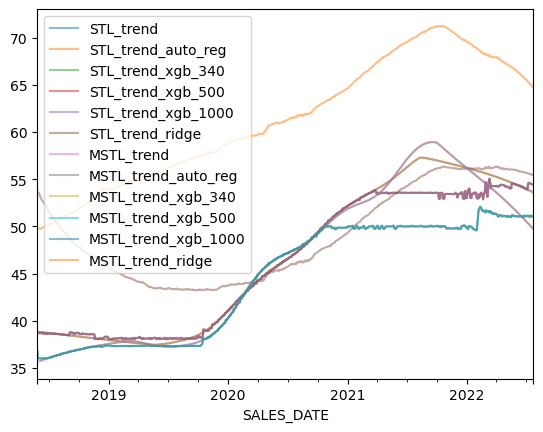

In [25]:
trend_cols = get_col_subset("trend",train_pred)
train_pred[trend_cols].plot(alpha = 0.5)

<AxesSubplot: xlabel='SALES_DATE'>

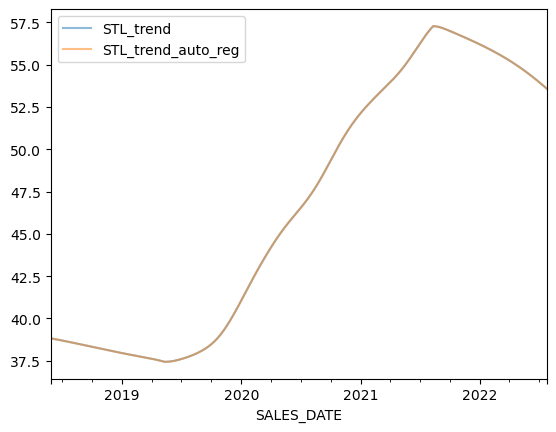

In [26]:
train_pred[["STL_trend","STL_trend_auto_reg"]].plot(alpha = 0.5)

In [27]:
train_pred.columns

Index(['STL_resid', 'STL_resid_auto_reg', 'STL_resid_xgb_340',
       'STL_resid_xgb_500', 'STL_resid_xgb_1000', 'STL_resid_ridge',
       'STL_trend', 'STL_trend_auto_reg', 'STL_trend_xgb_340',
       'STL_trend_xgb_500', 'STL_trend_xgb_1000', 'STL_trend_ridge',
       'STL_seasonal', 'STL_seasonal_auto_reg', 'STL_seasonal_xgb_340',
       'STL_seasonal_xgb_500', 'STL_seasonal_xgb_1000', 'STL_seasonal_ridge',
       'MSTL_resid', 'MSTL_resid_auto_reg', 'MSTL_resid_xgb_340',
       'MSTL_resid_xgb_500', 'MSTL_resid_xgb_1000', 'MSTL_resid_ridge',
       'MSTL_trend', 'MSTL_trend_auto_reg', 'MSTL_trend_xgb_340',
       'MSTL_trend_xgb_500', 'MSTL_trend_xgb_1000', 'MSTL_trend_ridge',
       'MSTL_seasonal_7', 'MSTL_seasonal_7_auto_reg',
       'MSTL_seasonal_7_xgb_340', 'MSTL_seasonal_7_xgb_500',
       'MSTL_seasonal_7_xgb_1000', 'MSTL_seasonal_7_ridge', 'MSTL_seasonal_30',
       'MSTL_seasonal_30_auto_reg', 'MSTL_seasonal_30_xgb_340',
       'MSTL_seasonal_30_xgb_500', 'MSTL_seasonal_3

<AxesSubplot: xlabel='SALES_DATE'>

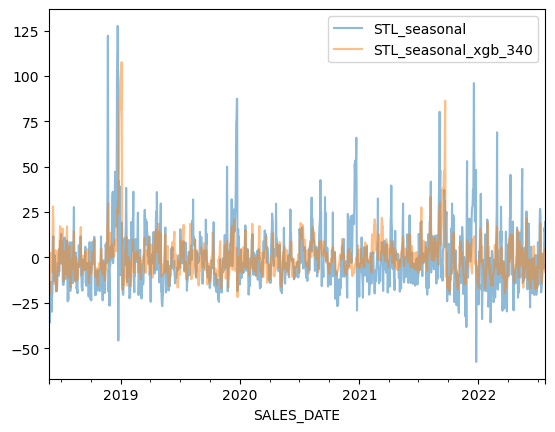

In [28]:
train_pred[["STL_seasonal","STL_seasonal_xgb_340"]].plot(alpha = 0.5)

<AxesSubplot: xlabel='SALES_DATE'>

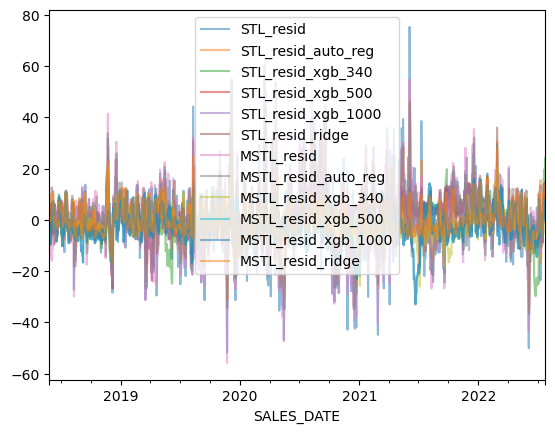

In [29]:
train_pred[get_col_subset("resid",train_pred)].plot(alpha = 0.5)

### RMSE pred

In [30]:
model_selected = "auto_reg"

In [31]:
y_pred = y_pred_dict[("STL_resid",model_selected)\
                    ] + y_pred_dict[("STL_trend",model_selected)\
                                   ] + y_pred_dict[("STL_seasonal",model_selected)]  
np.mean((validation_sku["DAILY_UNITS"]-y_pred)**2)**0.5

14.99500204189257

In [32]:
y_pred,validation_sku["DAILY_UNITS"]

(SALES_DATE
 2022-07-25    45.667673
 2022-07-26    37.621590
 2022-07-27    33.069367
 2022-07-28    30.407433
 2022-07-29    35.859179
 2022-07-30    35.272037
 2022-07-31    30.164481
 dtype: float64,
 SALES_DATE
 2022-07-25    25
 2022-07-26    33
 2022-07-27    44
 2022-07-28    49
 2022-07-29    43
 2022-07-30    55
 2022-07-31    45
 Name: DAILY_UNITS, dtype: object)

In [33]:
#wo residual
y_pred2 = y_pred_dict[("STL_trend",model_selected)\
                                   ] + y_pred_dict[("STL_seasonal",model_selected)]  
np.mean((validation_sku["DAILY_UNITS"]-y_pred2)**2)**0.5

11.244965799873484

In [34]:
y_pred2

SALES_DATE
2022-07-25    50.447733
2022-07-26    41.965236
2022-07-27    39.876440
2022-07-28    41.410245
2022-07-29    45.925033
2022-07-30    46.442125
2022-07-31    44.116246
dtype: float64